In [1]:
import sys
sys.path.insert(0,'/workspaces/RAG_secure_code_generation/src')
sys.path.insert(0,'/workspaces/RAG_secure_code_generation')
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json

In [2]:
summary_file = "../../experiments/task_detect_xss_simple_prompt/experiments_summary.csv"


In [3]:
df = pd.read_csv(summary_file)
df.head()

,Unnamed: 0,successes,failures,total,accuracy,accuracy_std,accuracy_var,precision,precision_std,precision_var,...,top_15_accuracy_var,top_15_precision,top_15_precision_std,top_15_precision_var,top_15_recall,top_15_recall_std,top_15_recall_var,top_15_f1,top_15_f1_std,top_15_f1_var
0,0,12,12,24,0.643709,0.160764,0.025845,0.730873,0.426559,0.181953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8,20,28,0.495102,0.001189,0.000001,0.125000,0.330719,0.109375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,8,15,23,0.609937,0.145118,0.021059,0.813137,0.347372,0.120667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,36,0,36,0.613990,0.165549,0.027407,0.688766,0.422505,0.178510,...,0.021011,0.952217,0.097153,0.009439,0.607079,0.310671,0.096517,0.676612,0.284872,0.081152
4,4,33,7,40,0.509779,0.047093,0.002218,0.310867,0.430912,0.185685,...,0.004275,0.683908,0.391640,0.153382,0.278891,0.405896,0.164751,0.233790,0.292698,0.085672


In [4]:
df.loc[df['generation_mode'] == 'zero_shot', 'examples_per_class'] = 0

In [5]:
# rename rag_few_shot to rag 
df['generation_mode'] = df['generation_mode'].replace('rag_few_shot', 'rag')
df['generation_mode'] = df['generation_mode'].replace('zero_shot', 'no_rag')
df['generation_mode'] = df['generation_mode'].replace('few_shot', 'no_rag')

df = df[['model_name', 'temperature', 'generation_mode','examples_per_class', 'folder']]



In [6]:
def from_folder_to_accuracy_list(folder:str)->list:
    folder = os.path.join('../..', folder)
    #find all the subfolder in folder:
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir() ]
    #map subfolder to the dict conteined in results.json file
    results = []
    for subfolder in subfolders:
        with open(os.path.join(subfolder, 'results.json')) as f:
            results.append(json.load(f))
    #keep only the results where failed is False
    results = [r for r in results if not r['failed']]
    #map results to accuracy
    results = [r['results']['accuracy'] for r in results]
    return results

In [7]:
df['accuracy'] = df['folder'].map(from_folder_to_accuracy_list)

In [8]:
#explode the accuracy list
df = df.explode('accuracy')
df.head()

,model_name,temperature,generation_mode,examples_per_class,folder,accuracy
0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.499262
0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.714273
0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.500922
0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.827033
0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.826388


In [9]:
#reinitialize the index
df = df.reset_index(drop=False)
df.head()

,index,model_name,temperature,generation_mode,examples_per_class,folder,accuracy
0,0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.499262
1,0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.714273
2,0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.500922
3,0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.827033
4,0,gpt-3.5-turbo-0125,0.5,rag,3,experiments/task_detect_xss_simple_prompt/temp...,0.826388


In [10]:
df["model_temperature"] = df["model_name"] + "_" + df["temperature"].astype(str)


In [11]:
df.examples_per_class.unique()

array([3, 1, 0, 5])

/tmp/ipykernel_1440280/999662452.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


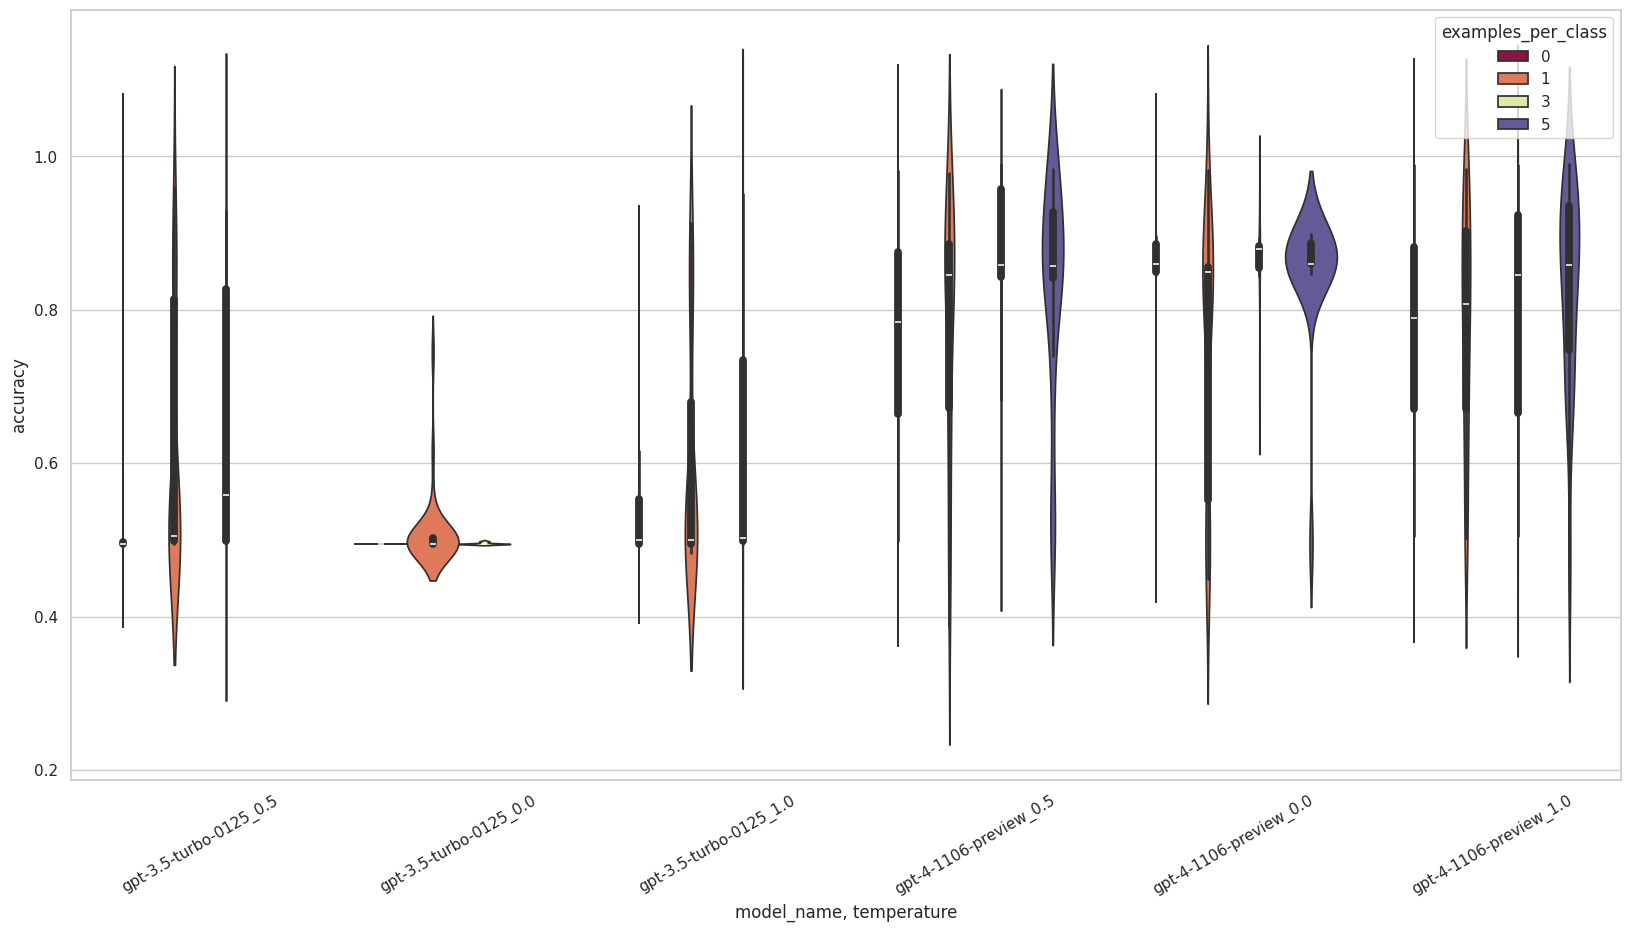

In [16]:
#draw boxplot  per model-temperature pair and examples_per_class
sns.set_theme(style="whitegrid")
#make figure larger
plt.figure(figsize=(20, 10))
ax = sns.violinplot(x="model_temperature", y="accuracy", hue="examples_per_class", data=df[df['generation_mode'] == 'rag'], palette="Spectral", legend = "full")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel("model_name, temperature")
ax.set_ylabel("accuracy")
#set legend using the hue values present in the dataset
plt.show()